# HLA-A allele clustering

## Section 1: Setup

In [1]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

Set up Classes:

In [2]:
Database_Name = "Gentype_DB.db"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

## Section 2: Collecting and preparing data

Fetches all HLA-A data obtained in 1000 Genomes project phase3 and stores them in a local sqlite server. This needs to be only done once but might take a while.

In [3]:
fetched = False
#%store -d fetched # if you want to refetch the data, uncomment this line
%store -r
if not fetched:
    data_manager.fetch_all(29941260, 29945884, "6", report_progress = True)
fetched = True
%store fetched

Stored 'fetched' (bool)


The following generates an inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. If _sum_allels = True_ is passed, the expression for an individual per allele will be summed (if expressed on both -> 2, on one -> 1, on neither -> 0). Otherwise each strand will be represented by a seperate row.

In [4]:
inference_matrix, individual_map, variation_map = data_manager.generate_inference_matrix(start = 29941260, end = 29945884, population = "ALL")
inference_matrix.shape

(5008, 438)

Mean number of variations per allele, for HLA-A as expected high.

In [5]:
inference_matrix.sum(axis=1).mean()

264.71665335463257

## Section 3: Training the Model

Train models with different initializations without seeding.

Here we compute different models with varying dirichlet prior alpha. This prior is proportional to the probability of creating a new cluster, therefore inference with high alphas tends to begin with a higher number of clusters. This might take a while.

Model 0:


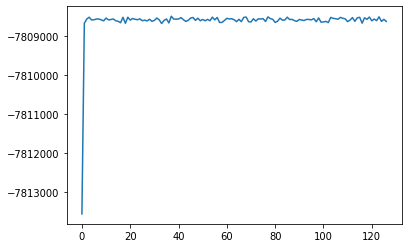

Model 1:


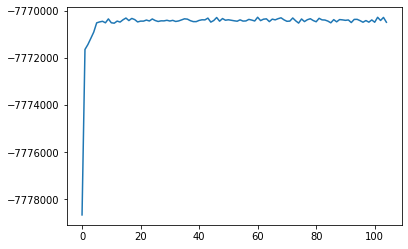

Model 2:


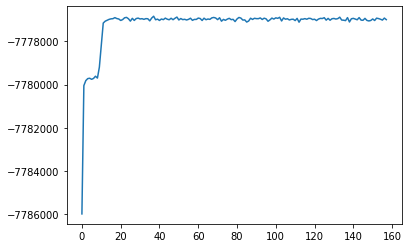

Stored 'models' (list)


In [7]:
models = None
#%store -d models # if you want to recompute the models, uncomment this line
%store -r
if models is None:
    models = [PiCollapsedNonparametricGibbsSampler(42), PiCollapsedNonparametricGibbsSampler(42), PiCollapsedNonparametricGibbsSampler(42)]
    for i in range(0, len(models)):
        print("Model {}:".format(i))
        models[i].fit(inference_matrix, num_burn_in_steps = 100, delta = 1, alpha = 10**(i - 1))
for i in range(0, len(models)):
    print("Model {}:".format(i))
    plt.clf()
    plt.plot(models[i].ll_list)
    plt.show()

%store models

May pre select models e.g. according to Aitikens Information Criterion (AIC)

In [39]:
def AIC(model):
    size = np.prod(np.shape(model.theta))
    loglikelihood =model.ll_list[-1]
    return 2*size - 2*loglikelihood

print(list(map(lambda x: AIC(x), models)))

[4697641.099421596, 4708175.190730272, 4714356.198959131]


## Section 4: Model analysis

In [40]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(inference_matrix)
pca.explained_variance_ratio_.cumsum()

array([0.33784928, 0.52281066])

Over 50% of the variation can be explained by the first two principle components !!!

In [41]:
inds = list(individual_map.keys())
inds.extend(list(individual_map.keys()))

populations = ["AFR", "AMR", "EAS", "EUR", "SAS"]
ind_map = data_manager.generate_individual_population_map()
population_index = []
for ind in inds:
    for pop in ind_map[ind]:
        if pop in populations:
            population_index.append(populations.index(pop))
pops = np.array(population_index)

Population distribution...

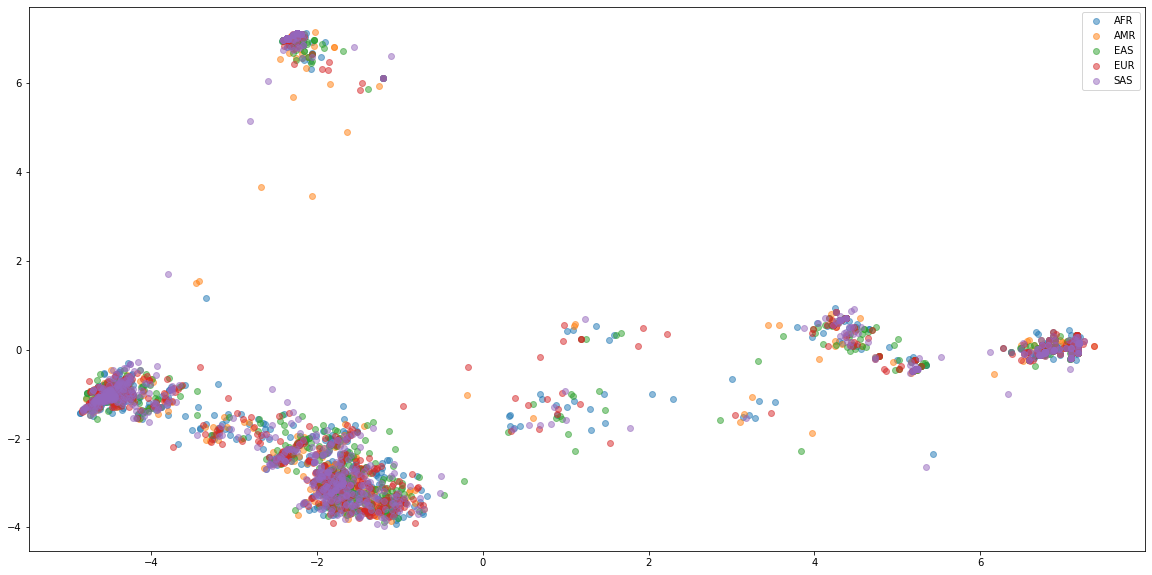

In [44]:
fig, ax = plt.subplots(figsize = (20,10))

for i in range(len(pops)):
    ax.plot(principalComponents[pops == i,0], principalComponents[pops == i,1], "o", alpha=0.5)
ax.legend(populations)

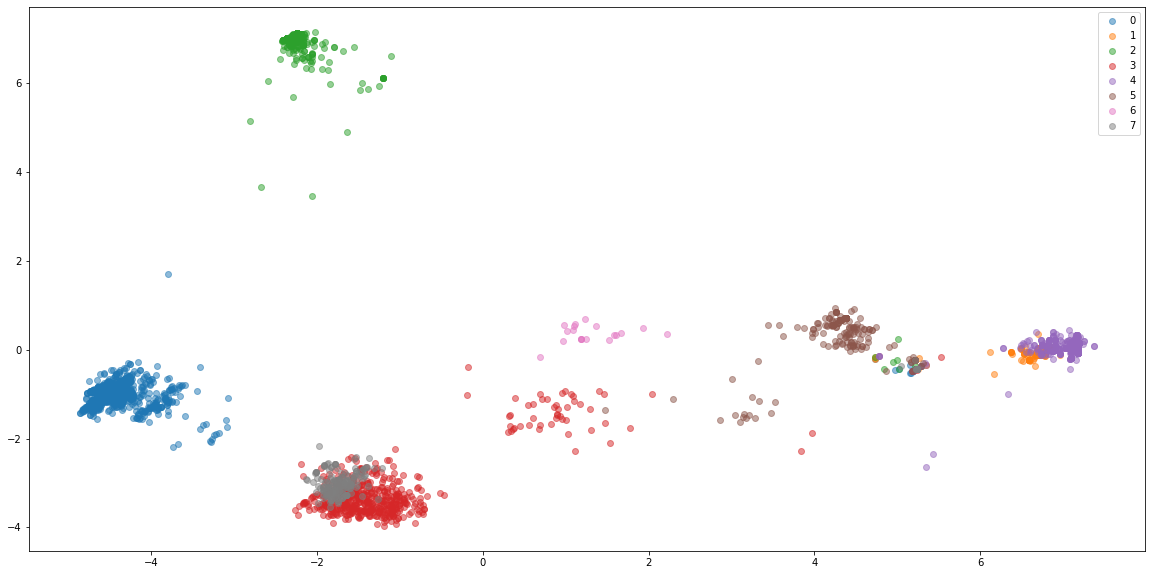

In [45]:
fig, ax = plt.subplots(figsize = (20,10))

for i in range(int(max(model1.Z))):
    ax.plot(principalComponents[model1.Z == i,0], principalComponents[model1.Z == i,1], "o", alpha=0.5)
ax.legend(range(int(max(model1.Z))))

In [46]:
df = pd.DataFrame(dict(zip(["Cluster " + str(i) for i in range(len(models[0].theta))], list(models[0].theta))))

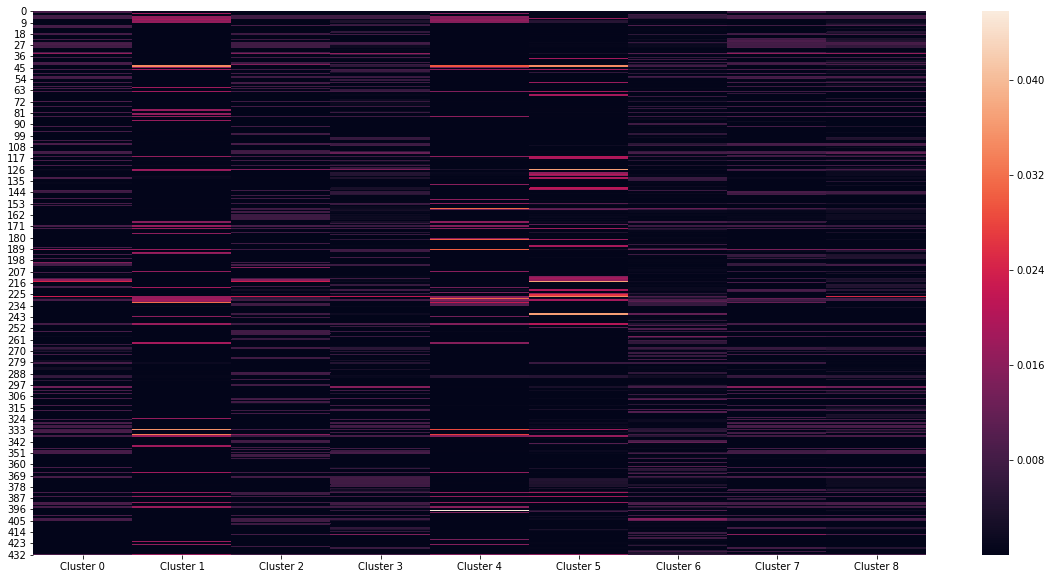

In [47]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df)

The following generates the distribution (as a dict) of amount of variations per strand in the specified region. I.e. {n : #strands with n variations}. And chooses one of the amounts according to the distribution.

In [25]:
distribution = data_manager.get_variation_distribution(start = 17671934, end = 17681934, population = "CHB")
choices = []
probabilities = []
for choice in distribution:
    choices.append(choice)
    probabilities.append(distribution[choice])
choices = np.array(choices)
probabilities = np.array(probabilities) / sum(probabilities)
print("Choices: {}".format(choices))
print("Probabilities: {}".format(probabilities))
np.random.choice(choices, p=probabilities)